In [1]:
from sklearn import metrics
!pip install scipy numpy matplotlib pandas sklearn tabulate seaborn folium geopy geopandas requests> /dev/null
%matplotlib notebook

System nie moľe odnale«† okre�lonej �cieľki.


In [2]:
# import importlib
# import sys
# importlib.reload(sys.modules['statistics.company'])
# Load libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib import pyplot
from sklearn.model_selection import train_test_split, learning_curve, permutation_test_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import normalize
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, plot_roc_curve, auc
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import calinski_harabasz_score, davies_bouldin_score, silhouette_score
from sklearn.cluster import KMeans
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.linear_model import Lasso
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from tabulate import tabulate
from IPython.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))
import os
import sys
from numpy import arange, append

from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, make_scorer
sys.path.insert(0, os.path.abspath('./module-dir'))

In [3]:
from dataset_provider.provider import get_dataset
from dataset_provider.config import create_global_config
cfg = create_global_config()
df = get_dataset(cfg)

Taking data from local file...
Found 307 job ads without salary range or currency
(1238, 36)
        salary_from     salary_to
count   1238.000000   1238.000000
mean   11153.838449  15901.235057
std     4526.953767   5095.306580
min     1250.000000   1750.000000
25%     8000.000000  12000.000000
50%    10000.000000  16000.000000
75%    14000.000000  19000.000000
max    44000.000000  50000.000000
Found 8 countries and 4 currencies!
Dropping foreign countries and translating currencies...
Unique countries: 1, currencies: 1, observations: 1218


C:\Users\Pacia\Anaconda3\lib\site-packages\pandas\core\indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


---------------------------------------------------------------------------

# Classification

In [4]:
cl_df = df.copy()
for col in ["city", "Unnamed: 0", "title", "company_size", "country_code", "marker_icon", "company_name",
            "latitude", "longitude", "salary_currency", "published_at", "remote_interview", "id",
            "skills", "-", 'remote',  'employment_type','salary_from', 'salary_to' ]: #'salary_from', 'salary_to'
                cl_df=cl_df.drop(col, axis=1)
print(cl_df.columns)
cols_for_encoding = [c for c in cl_df.select_dtypes(include=['object']).copy().columns if c != "experience_level"]
print(cols_for_encoding)
cl_df = pd.get_dummies(cl_df, columns=cols_for_encoding)

#cl_df.loc[df["Java"] > 0] = cl_df.loc[df["Java"] > 0]
cl_df = cl_df[cl_df['Frontend']!=0]
cl_df = cl_df[cl_df['experience_level'] != 'junior']
cl_df = cl_df[cl_df['experience_level'] == 'mid'][:136].append(cl_df[cl_df['experience_level'] == 'senior'])
print(cl_df['experience_level'].unique())
print(cl_df['experience_level'].value_counts())

Index(['experience_level', 'Backend', 'Design', 'Network', 'DataScience',
       'Embedded', 'Cloud', 'Database', 'Mobile', 'IT', 'Management',
       'Frontend', 'DevOps', 'Testing', 'Blockchain', 'Games', 'SAP'],
      dtype='object')
[]
['mid' 'senior']
mid       136
senior    136
Name: experience_level, dtype: int64


In [5]:
print(len(cl_df.columns))

17


In [6]:
def move_col_to_end(df, col):
    cols_at_end = [col]
    return df[[c for c in df if c not in cols_at_end]
              + [c for c in cols_at_end if c in df]]


cl_df = move_col_to_end(cl_df, "experience_level")
array = cl_df.values
x = array[:, 0:len(cl_df.columns) - 1]
y = array[:, len(cl_df.columns) - 1]
x = normalize(x)
le = LabelEncoder()
y = le.fit_transform(y)

In [7]:
# array = cl_df.values
# x = array[:, 0:len(cl_df.columns)-1]
# y = array[:, len(cl_df.columns)-1]
# x = normalize(x)
# print(x[0])

In [8]:
# from sklearn.preprocessing import StandardScaler
# scaler = StandardScaler()  # doctest: +SKIP
# scaler.fit(x)  # doctest: +SKIP
# x = scaler.transform(x)

print(x)

[[0.70710678 0.         0.         ... 0.         0.         0.        ]
 [0.62469505 0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 ...
 [0.         0.6        0.         ... 0.         0.         0.        ]
 [0.62469505 0.         0.         ... 0.         0.         0.        ]
 [0.75257669 0.         0.         ... 0.         0.         0.        ]]


Best parameters below (CV score=0.577):


'<table>\n<thead>\n<tr><th>AdaBoost__algorithm  </th><th style="text-align: right;">  AdaBoost__learning_rate</th><th style="text-align: right;">  AdaBoost__n_estimators</th><th style="text-align: right;">  pca__n_components</th></tr>\n</thead>\n<tbody>\n<tr><td>SAMME                </td><td style="text-align: right;">                        1</td><td style="text-align: right;">                       1</td><td style="text-align: right;">                  1</td></tr>\n</tbody>\n</table>'

<IPython.core.display.Javascript object>


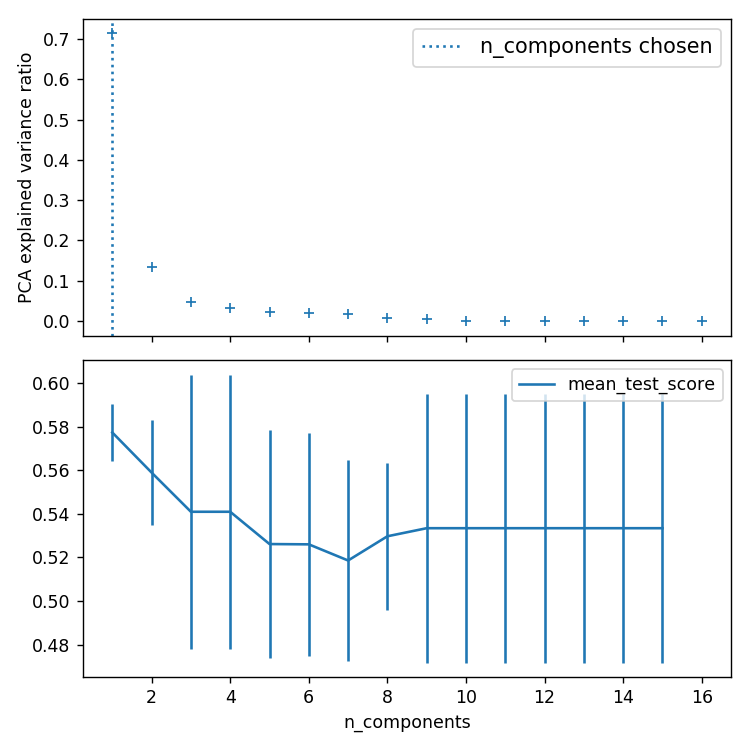

In [10]:
def try_all_params_combinations(x, y, name, model, params):
    # update params keys to format name__model-name to fit to grid
    for key in params.copy().keys():
        params[f"{name}__{key}"] = params.pop(key)
    pca = PCA()
    pipe = Pipeline(steps=[('pca', pca), (name, model)])
    param_grid = {'pca__n_components': range(1, len(x[0]))} # leave 1-all features
    param_grid.update(params)
    search = GridSearchCV(pipe, param_grid, n_jobs=-1, scoring=make_scorer(mean_absolute_error))
    search.fit(x, y)
    print("Best parameters below (CV score=%0.3f):" % search.best_score_)
    display(tabulate([list(search.best_params_.values())], list(search.best_params_.keys()), tablefmt="html"))
    
    # Plot the PCA spectrum
    pca.fit(x)
    
    fig, (ax0, ax1) = plt.subplots(nrows=2, sharex=True, figsize=(6, 6))
    ax0.plot(np.arange(1, pca.n_components_ + 1), pca.explained_variance_ratio_, '+', linewidth=2)
    ax0.set_ylabel('PCA explained variance ratio')
    ax0.axvline(search.best_estimator_.named_steps['pca'].n_components, linestyle=':', label='n_components chosen')
    ax0.legend(prop=dict(size=12))

    # For each number of components, find the best classifier results
    results = pd.DataFrame(search.cv_results_)
    components_col = 'param_pca__n_components'
    best_clfs = results.groupby(components_col).apply( lambda g: g.nlargest(1, 'mean_test_score'))
    best_clfs.plot(x=components_col, y='mean_test_score', yerr='std_test_score', legend=True, ax=ax1)
    ax1.set_xlabel('n_components')

    plt.tight_layout()
    plt.show()
    return search

models = [
#     ('CART', DecisionTreeClassifier(), { 
#     'criterion' : ['gini', 'entropy'],
# #     'n_estimators': range(1, 200, 25),
#     'max_depth': append(range(2, 3), [None]),
#     'random_state': [True],
#     'min_samples_leaf': range(1, 10),
#     'max_features': ['auto','sqrt', 'log2'],
#     'class_weight': ['balanced', None] 
#     }),
    ('AdaBoost', AdaBoostClassifier(), { 
    'learning_rate' : range(1, 5, 1),
    'n_estimators': range(1, 200, 25),
    'algorithm' : ['SAMME','SAMME.R']
    })
#     ('RandomForest', RandomForestClassifier(), { 
#     'n_estimators': range(1, 200, 25),
#     'max_depth': append(range(2, 3), [None]),
#     'random_state': [True],
#     'min_samples_leaf': range(1, 10),
#     'max_features': ['auto','sqrt', 'log2'],
#     'class_weight': ['balanced', 'balanced_subsample'] 
#     })
    ]
# ---------------- Runtime ------------------------ #

best_models = {}
for name, model, params in models:
    best_models[name] = try_all_params_combinations(x, y, name, model, params)

In [ ]:
def move_col_to_end(df, col):
    cols_at_end = [col]
    return df[[c for c in df if c not in cols_at_end] 
            + [c for c in cols_at_end if c in df]]

cl_df = move_col_to_end(cl_df, "experience_level")
array = cl_df.values
x = array[:,0:len(cl_df.columns)-1]
y = array[:,len(cl_df.columns)-1]
x = normalize(x)
le = LabelEncoder()
y = le.fit_transform(y)
#na podstawie x i y otrzymujemy tablice testowe i wynikowe
x_train, x_validation, y_train, y_validation = train_test_split(x,y, test_size=cfg.test_size, random_state=1)

In [ ]:
models = []
models.extend([
#     ('KNN', KNeighborsClassifier(), 0),
    ('CART', DecisionTreeClassifier(), 1),
        ('RANDOMFOREST', RandomForestClassifier(), 2)
#     ('NB', GaussianNB(), 2),
#     ('SVM', SVC(gamma='auto'), 3),
#     ('MLP', MLPClassifier(alpha=1e-5, hidden_layer_sizes=(50,10), max_iter=5000), 4)
    ])
def plot_show():
    pyplot.draw()
    pyplot.pause(0.1)

def get_specificity(y_validate, y_predicted):
    cnf_matrix = confusion_matrix(y_validate, y_predicted)
    
    FP = cnf_matrix.sum(axis=0) - np.diag(cnf_matrix)  
    FN = cnf_matrix.sum(axis=1) - np.diag(cnf_matrix)
    TP = np.diag(cnf_matrix)
    TN = cnf_matrix.sum() - (FP + FN + TP)
    
    FP = FP.astype(float)
    TN = TN.astype(float)
        
    return np.mean(TN/(TN+FP))
    
def get_learning_curve(classification_model, training_set_enlarging_step=10):
    train_sizes = np.linspace(0.1, 1, training_set_enlarging_step)
    train_sizes, train_scores, validation_scores = learning_curve(
        estimator = classification_model,
        X = x,
        y = y, 
        train_sizes = train_sizes,
        cv = 5,
        scoring = 'accuracy')
    return train_sizes, train_scores, validation_scores

def plot_learning_curve(model,name):
    train_sizes, train_scores, test_scores = \
        get_learning_curve(model)

    plt.style.use('seaborn')
    plt.plot(train_sizes, -train_scores.mean(axis = 1), color= 'red', label = 'Training error')
    plt.plot(train_sizes, -test_scores.mean(axis = 1), color= 'navy',label = 'Validation error')
    plt.ylabel('Accuracy', fontsize = 14)
    plt.xlabel('Training set size', fontsize = 14)
    plt.title('Learning curves for a %s' % name, fontsize = 18, y = 1.03)
    plt.legend()
    plt.show()
    
def compare_algorithms(results, names):
    fig = pyplot.figure()
    fig.suptitle("Algorithm Comparison")
    ax = fig.add_subplot(1,1,1)
    ax.set_title("Algorithm Comparison")
    ax.boxplot(results, labels=names)
    plot_show()

def print_scores(cv_results, predictions):
    print('\nMean %f' % cv_results.mean())
    print('STD %f' % cv_results.std())
    print('\nConfusion matrix:')
    print(confusion_matrix(y_validation, predictions))
    print('\nAccuracy %f' % accuracy_score(y_validation, predictions))
    print('Precision %f' % precision_score(y_validation, predictions, average = 'weighted'))
    print('Recall %f' % recall_score(y_validation, predictions, average = 'weighted'))
    print('Specificity %f' % get_specificity(y_validation, predictions))
    print('\nClassification report:')
    print(classification_report(y_validation, predictions))

def plot_roc_curves():
    fig = pyplot.figure()
    ax = plt.gca()
    for name, model, subplot_row in models:
        rfc_disp = plot_roc_curve(model, x_validation, 
                                  y_validation, ax=ax, alpha=0.8)
    plt.show()

def accuracySignificancy(model, x_train, y_train, cv):
    fig = pyplot.figure()
    fig.suptitle("Estimating accuracy score's statistical significancy")
    ax = fig.add_subplot(1,1,1)
    n_classes = np.unique(y_train).size
    score, permutation_scores, pvalue = permutation_test_score(model, x_train, y_train, scoring="accuracy", cv=cv, n_permutations=100)
    print("Classification score %s (pvalue : %s)" % (score, pvalue))
    # View histogram of permutation scores
    ax.hist(permutation_scores, 20, label='Permutation scores',
             edgecolor='black')
    ylim = plt.ylim()
    ax.set_xlabel('Score')
    plt.show()

def evaluate_per_dataset():
    results = []
    names = []
    
    for name, model, subplot_row in models:
            print(f"---------------------------\nRunning classification for: {name}")
            kfold = StratifiedKFold(n_splits=4, random_state=1, shuffle=True)
            cv_results = cross_val_score(model, x_train, y_train, cv=kfold, scoring='accuracy')
            accuracySignificancy(model, x_train, y_train, kfold)
            results.append(cv_results)
            names.append(name)

            # Make predictions on validation dataset
            model.fit(x_train, y_train)
            predictions = model.predict(x_validation)
            
            print_scores(cv_results, predictions)
            plot_learning_curve(model,name)

    # Compare Algorithms - ROC etc
    compare_algorithms(results, names)

In [ ]:
evaluate_per_dataset()